In [177]:
import pandas as pd
import numpy as np
import helper_functions as sc
import datetime

import pickle

from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

In [178]:
features = ['goal_difference_1', 'form_1', 'form_weighted_1',
           'form_possession_1', 'form_pass_acc_1', 'form_shot_acc_1',
           'form_duels_1', 'form_offense_1', 'goal_difference_2', 'form_2',
           'form_weighted_2', 'form_possession_2', 'form_pass_acc_2',
           'form_shot_acc_2', 'form_duels_2', 'form_offense_2', 'home_away',
            'team_1_B', 'team_1_C', 'team_1_D', 'team_2_B', 'team_2_C', 'team_2_D']

In [179]:
# load data
league = 'bundesliga'
years = ['2016', '2017']

data_training = pd.DataFrame()
for year in years:
    data = pd.read_csv('data/' + league +'_'+ year + '_ready.csv', index_col=0)
    data_training = data_training.append(data)
data_training.shape

C:\Users\kr_fl\anaconda\lib\site-packages\pandas\core\frame.py:6701: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(1188, 31)

In [180]:
# get features and target dataframes
X_train = data_training[features]
y_train = data_training['target']
features = list(X_train.columns)

# Normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_train.columns = features
X_train.head()

C:\Users\kr_fl\anaconda\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,goal_difference_1,form_1,form_weighted_1,form_possession_1,form_pass_acc_1,form_shot_acc_1,form_duels_1,form_offense_1,goal_difference_2,form_2,...,form_shot_acc_2,form_duels_2,form_offense_2,home_away,team_1_B,team_1_C,team_1_D,team_2_B,team_2_C,team_2_D
0,0.346154,0.000000,0.000000,0.364465,0.717791,0.000000,0.526786,0.000000,0.413462,1.000000,...,0.573333,0.883929,1.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.413462,1.000000,1.000000,0.911162,0.993865,0.573333,0.883929,1.000000,0.346154,0.000000,...,0.000000,0.526786,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.365385,0.500000,0.375000,0.501139,0.656442,0.613333,0.705357,0.333333,0.336538,0.166667,...,1.000000,0.660714,0.166667,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.336538,0.166667,0.083333,0.391800,0.365031,1.000000,0.660714,0.166667,0.365385,0.500000,...,0.613333,0.705357,0.333333,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.336538,0.166667,0.083333,0.624146,0.717791,0.133333,0.392857,0.083333,0.384615,1.000000,...,0.486667,0.549107,0.333333,1.0,0.0,0.0,1.0,0.0,0.0,0.0


## train models on last season

In [181]:
# init model list
model_list = []

In [182]:
#########################################
# Model 1 - logistic regression - Ridge #
#########################################

mdl_ridge = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000, multi_class = 'auto') # Ridge

# folds
kfold = KFold(n_splits=5, shuffle = True, random_state = 1)

# gridsearch cv
param_grid = [{
    'C': [1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
}]

search = GridSearchCV(mdl_ridge, param_grid, cv=kfold, 
                      scoring = 'accuracy',
                      return_train_score=True, iid=False)
search.fit(X_train, y_train)
mdl_ridge = search.best_estimator_

print(mdl_ridge)
print(search.best_score_)

if search.best_score_ > 0.5:
    model_list += mdl_ridge

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
0.47058114385


In [183]:
##################################
# Model 2 - k-neirest neighbors ##
##################################

mdl_knn = KNeighborsClassifier()  

# folds
kfold = KFold(n_splits=5, shuffle = True, random_state = 1)

# gridsearch cv
param_grid = [{
    'n_neighbors': [i for i in range(1,100)]
}]

search = GridSearchCV(mdl_knn, param_grid, cv=kfold, 
                      scoring = 'accuracy',
                      return_train_score=True, iid=False)

search.fit(X_train, y_train)
mdl_knn = search.best_estimator_

print(mdl_knn)
print(search.best_score_)

if search.best_score_ > 0.5:
    model_list.append(mdl_knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform')
0.571524305925


In [184]:
###########################
# model 3 - random forest #
###########################

mdl_rf = RandomForestClassifier(min_samples_leaf=5, random_state=1, n_jobs=-1)

# folds
kfold = KFold(n_splits=5, shuffle = True, random_state = 1)

# gridsearch cv
param_grid = [{
    'n_estimators': [500, 1000],
    'max_depth': [i for i in range(5,20)],
    'max_features': ['sqrt', 'log2']
}]

search = GridSearchCV(mdl_rf, param_grid, cv=kfold, 
                      scoring = 'accuracy',
                      return_train_score=True, iid=False)

search.fit(X_train, y_train)
mdl_rf = search.best_estimator_

print(mdl_rf)
print(search.best_score_)

feature_importance = (pd.DataFrame({'features': X_train.columns,
                                    'importance': mdl_rf.feature_importances_})
                        .sort_values('importance', ascending=False))
print(feature_importance)

if search.best_score_ > 0.5:
    model_list.append(mdl_rf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=19, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)
0.56483707407
             features  importance
16          home_away    0.097180
13    form_shot_acc_2    0.068897
5     form_shot_acc_1    0.064386
9              form_2    0.064364
8   goal_difference_2    0.062336
0   goal_difference_1    0.055343
12    form_pass_acc_2    0.054276
11  form_possession_2    0.054214
4     form_pass_acc_1    0.053434
3   form_possession_1    0.053328
6        form_duels_1    0.051992
14       form_duels_2    0.051945
1              form_1    0.051644
2     form_weighted_1    0.048666
10    form_weighted_2    0.047902
15     form_offense_2    0.044051
7 

In [185]:
#############################
# model 4 - neural network  #
#############################

mdl_mlp = MLPClassifier(hidden_layer_sizes = (50, 50), activation='relu', alpha=0.0001, solver='lbfgs',
                        batch_size=20, learning_rate='invscaling', learning_rate_init=0.001)

kfold = KFold(n_splits=5, shuffle = True, random_state = 1)

# gridsearch cv
param_grid = [{
    'hidden_layer_sizes': [(10,), (10,10), (10,10,10), (50,), (100,), (150,), (100, 100), (100,100,100)],
    'alpha': [0.0001, 0.001, 0.01, 1, 10]
}]

search = GridSearchCV(mdl_mlp, param_grid, cv=kfold, 
                      scoring = 'accuracy',
                      return_train_score=True, iid=False)

search.fit(X_train, y_train)
mdl_mlp = search.best_estimator_

print(mdl_mlp)
print(search.best_score_)

if search.best_score_ > 0.5:
    model_list.append(mdl_mlp)

MLPClassifier(activation='relu', alpha=10, batch_size=20, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='invscaling',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
0.616959188739


In [186]:
###########################
# model 5 - Naive Bayes   #
###########################

mdl_bay = GaussianNB()

kfold = KFold(n_splits=5, shuffle = True, random_state = 1)

cv_result = cross_validate(mdl_bay, X_train, y_train, cv=kfold, scoring='accuracy')
mdl_bay.fit(X_train, y_train)

print(np.mean(cv_result['test_score']))

if np.mean(cv_result['test_score']) > 0.5:
    model_list.append(mdl_mlp)

0.370361309081


In [188]:
model_list

[KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=15, p=2,
            weights='uniform'),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=19, max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=5, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
             oob_score=False, random_state=1, verbose=0, warm_start=False),
 MLPClassifier(activation='relu', alpha=10, batch_size=20, beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=(100, 100), learning_rate='invscaling',
        learning_rate_init=0.001, max_iter=200, momentum=0.9,
        n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
        random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
        validation_f

In [189]:
#################################################
# Ensemble - setup logistic regression - lasso  #
#################################################

# get features
X_ensemble = sc.get_ensemble_x(X_train, model_list)

# train logistic regression ensemble
mdl_lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=100, multi_class = 'auto')

# folds
kfold = KFold(n_splits=5, shuffle = True, random_state = 1)

# gridsearch cv
param_grid = [{
    'C': [3000, 2000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
}]

search = GridSearchCV(mdl_lasso, param_grid, cv=kfold, 
                      scoring = 'accuracy',
                      return_train_score=True, iid=False)

search.fit(X_ensemble, y_train.reset_index(drop=True))
mdl_ensemble = search.best_estimator_

modelname = type(mdl_ensemble).__name__
filename = 'data/models/' + league + '/Ensemble/' + years[-1] +'_'+ modelname +'_newest' 
print('saved : ', filename)
pickle.dump(mdl_ensemble, open(filename, 'wb'))

print(mdl_ensemble)
print(search.best_score_)

saved :  data/models/bundesliga/Ensemble/2017_LogisticRegression_newest
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
0.992426337624


In [190]:
"""from joblib import dump, load

for model in model_list:
    modelname = type(model).__name__
    filename = ligue + years[-1] + modelname +'newest.joblib'
    print(filename)
    dump(model, 'filename.joblib') 
"""

"from joblib import dump, load\n\nfor model in model_list:\n    modelname = type(model).__name__\n    filename = ligue + years[-1] + modelname +'newest.joblib'\n    print(filename)\n    dump(model, 'filename.joblib') \n"

In [191]:
# save models in model_list
for model in model_list:
    modelname = type(model).__name__
    filename = 'data/models/' + league +'/' + years[-1] +'_'+ modelname +'_newest'
    print('saved: ', filename)
    pickle.dump(model, open(filename, 'wb'))

saved:  data/models/bundesliga/2017_KNeighborsClassifier_newest
saved:  data/models/bundesliga/2017_RandomForestClassifier_newest
saved:  data/models/bundesliga/2017_MLPClassifier_newest


In [192]:
# load models
import os
league = 'bundesliga'
years = ['2017']
folder = os.listdir(os.getcwd() + '\\data\\models\\' + league)

model_list = []
for model in folder:
    if model.startswith(years[-1]):
        filename = os.getcwd() + '\\data\\models\\' + league +'\\' +model
        model_list.append(pickle.load(open(filename, 'rb')))
        print('loaded :', model)

modelname = 'LogisticRegression'
filename = 'data/models/' + league + '/Ensemble/' + years[-1] +'_'+ modelname +'_newest' 
mdl_ensemble = pickle.load(open(filename, 'rb'))
print('loaded :', filename)

if not model_list:
    print('error: no  models loaded')

loaded : 2017_KNeighborsClassifier_newest
loaded : 2017_MLPClassifier_newest
loaded : 2017_RandomForestClassifier_newest
loaded : data/models/bundesliga/Ensemble/2017_LogisticRegression_newest


## Simulation of next season

In [193]:
# load new season data
folder = os.getcwd() + '\\data\\'
filename = league + '_' + str(int(years[-1]) + 1) + '_ready.csv'

data_test = pd.read_csv(folder + filename, index_col=0)

print(data_test.shape, '\n year', str(int(years[-1]) + 1))
data_test.head()

(594, 33) 
 year 2018


,round,team_1,goal_difference_1,form_1,form_weighted_1,form_possession_1,form_pass_acc_1,form_shot_acc_1,form_duels_1,form_offense_1,...,match_date,B365H,B365D,B365A,team_1_B,team_1_C,team_1_D,team_2_B,team_2_C,team_2_D
0,Regular Season - 2,166,0,1.0,2.0,48.0,81.0,0.250,47.0,1.0,...,08/31/2018,5.50,4.33,1.57,0,1,0,0,0,0
1,Regular Season - 2,165,3,3.0,12.0,49.0,78.0,0.800,42.0,4.0,...,08/31/2018,5.50,4.33,1.57,0,0,0,0,1,0
2,Regular Season - 2,167,0,1.5,3.0,48.0,78.0,0.315,45.0,2.0,...,09/01/2018,1.55,4.00,6.50,0,1,0,0,0,1
3,Regular Season - 2,160,-4,0.0,0.0,45.0,75.5,0.085,52.0,0.5,...,09/01/2018,1.55,4.00,6.50,0,0,1,0,1,0
4,Regular Season - 2,168,-4,0.0,0.0,50.5,81.5,0.165,52.5,0.5,...,09/01/2018,1.61,4.33,5.00,0,0,1,0,0,0


In [194]:
# simulation
results = pd.DataFrame()

print('starting simulation')

for gameday in data_test['round'].unique():
    gameday_data = data_test[data_test['round'] == gameday]
    
    X = gameday_data[features]
    y = gameday_data['target']
    features = list(X.columns)
    
    # Normalization
    X = scaler.transform(X)
    X = pd.DataFrame(X)
    X.columns = features
    
    # get ensemble features
    X_ensemble = sc.get_ensemble_x(X, model_list)
    
    # predict with ensemble model
    y_hat = mdl_ensemble.predict(X_ensemble)
    y_hat_proba = mdl_ensemble.predict_proba(X_ensemble)
    # create column with bet or no bet according to threshold
    bet = [any(y_hat_proba[i] > 0.8) for i in range(len(y_hat_proba))]
    
    match_day_result = pd.DataFrame({'gameday': list(np.repeat(gameday, len(y))),
                                           'y':y,
                                           'y_hat':y_hat,
                                           'y_hat_proba': [np.amax(i) for i in y_hat_proba],
                                           'bet': bet,
                                           'odds_home': gameday_data['B365H'],
                                           'odds_draw': gameday_data['B365D'],
                                           'odds_away': gameday_data['B365A'],
                                           'home_away' : gameday_data['home_away'],
                                           'match_id': gameday_data['match_id']})
    
    results = results.append(match_day_result)
    
    # retrain models with latest gameday
    X_train = X_train.append(X)
    y_train = y_train.append(y)
    
    for model in model_list:
        model.fit(X_train, y_train)
        
    X_ensemble = sc.get_ensemble_x(X_train, model_list)
    mdl_ensemble.fit(X_ensemble, y_train)
    
    print('finished simulating gameday: ', gameday)
    print('tipped right on ' 
          +str(sum(match_day_result['y'] == match_day_result['y_hat']))
          +'/'+str(len(match_day_result))
          +' matches')
print('end of simulation...')

starting simulation
finished simulating gameday:  Regular Season - 2
tipped right on 6 from possible 18 matches
finished simulating gameday:  Regular Season - 3
tipped right on 14 from possible 18 matches
finished simulating gameday:  Regular Season - 4
tipped right on 9 from possible 18 matches
finished simulating gameday:  Regular Season - 5
tipped right on 9 from possible 18 matches
finished simulating gameday:  Regular Season - 6
tipped right on 8 from possible 18 matches
finished simulating gameday:  Regular Season - 7
tipped right on 6 from possible 18 matches
finished simulating gameday:  Regular Season - 8
tipped right on 11 from possible 18 matches
finished simulating gameday:  Regular Season - 9
tipped right on 7 from possible 18 matches
finished simulating gameday:  Regular Season - 10
tipped right on 13 from possible 18 matches
finished simulating gameday:  Regular Season - 11
tipped right on 12 from possible 18 matches
finished simulating gameday:  Regular Season - 12
tipp

## Accuracy 

In [196]:
print('tipped right on ' +str(sum(results['y'] == results['y_hat']))+'/'+str(len(results)) + ' matches')
print('final accuracy of ensemble on test set =' , round(accuracy_score(results['y'], results['y_hat']), 4))
print('\n confusion matrix: \n', confusion_matrix(results['y'], results['y_hat']))  
print('\n', classification_report(results['y'], results['y_hat'])) 

results_bet = results[results['bet'] == True]
print('final accuracy of ensemble on test set with threshold = ',
      round(accuracy_score(results_bet['y'], results_bet['y_hat']), 4))
print('number of bets = ', len(results_bet), '\n max bets: ', len(results))

tipped right on 347/594 matches
final accuracy of ensemble on test set = 0.5842

 confusion matrix: 
 [[ 98  46  42]
 [ 27  49  68]
 [ 23  41 200]]

               precision    recall  f1-score   support

           0       0.66      0.53      0.59       186
           1       0.36      0.34      0.35       144
           3       0.65      0.76      0.70       264

   micro avg       0.58      0.58      0.58       594
   macro avg       0.56      0.54      0.54       594
weighted avg       0.58      0.58      0.58       594

final accuracy of ensemble on test set with threshold =  0.6199
number of bets =  463 
 max bets:  594


# Assessment earnings

In [197]:
results_final = results[results['home_away'] == 1]
results_final.head()

,gameday,y,y_hat,y_hat_proba,bet,odds_home,odds_draw,odds_away,home_away,match_id
0,Regular Season - 2,1,0,0.999517,True,5.50,4.33,1.57,1,2526
2,Regular Season - 2,3,3,0.999998,True,1.55,4.00,6.50,1,2527
4,Regular Season - 2,0,1,0.536307,False,1.61,4.33,5.00,1,2528
6,Regular Season - 2,0,0,0.633763,False,2.40,3.50,2.90,1,2529
8,Regular Season - 2,1,3,1.000000,True,2.62,3.40,2.70,1,2530


In [198]:
def get_game_revenue(game, bet):
    revenue = 0
    revenue -= bet
    if (game['y'] == game['y_hat']):
        if game['y'] == 1:
            revenue += bet*game['odds_draw']
        if game['home_away'] == 1:
            if game['y'] == 3: # win
                revenue += bet*game['odds_home']
            if game['y'] == 0: # loose
                revenue += bet*game['odds_away']
        if game['home_away'] == 0:
            if game['y'] == 3: # win
                revenue += bet*game['odds_away']
            if game['y'] == 0: # loose
                revenue += bet*game['odds_home']
    return revenue

In [199]:
# simulate season
bet = 100
budget = 1000
print(league, str(int(years[-1])+1))
print('initial budget ', budget)
print('betsize', bet)

# revenue
results_final['revenue'] = results_final.apply(lambda x: get_game_revenue(x, bet), axis=1)

# budget
for _, game in results_final.iterrows():
    #print('playing '+ game['gameday'] +' match '+ str(game['match_id']))
    budget += game['revenue']
    if budget <= bet:
        print('budget is empty on gameday ' + game['gameday'] +' match '+ str(game['match_id']))
        break
        
print('final value ', budget)

bundesliga 2018
initial budget  1000
betsize 100
final value  10972.0


C:\Users\kr_fl\anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [200]:
# save results
results_final.to_csv('data\\results\\' + league + str(int(years[-1])+1) + '.csv')

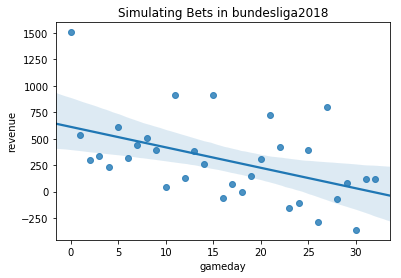

In [204]:
# plot gameday results
import seaborn as sns
import matplotlib.pyplot as plt

plot = results_final.groupby('gameday')['revenue'].sum().reset_index()
sns.regplot(x=list(plot.index) ,y=plot['revenue'])
plt.title('Simulating Bets in ' + league + str(int(years[-1])+1))
plt.xlabel('gameday')
plt.show()


In [173]:
bad_days = list(plot[plot['revenue'] < 0]['gameday'].unique())
results_final[results_final['gameday'].isin(bad_days)]

,gameday,y,y_hat,y_hat_proba,bet,odds_home,odds_draw,odds_away,home_away,match_id,revenue
18,Bundesliga - 3,0,3,0.992098,True,4.00,3.60,1.91,1,11207,-100.0
20,Bundesliga - 3,0,3,0.997209,True,1.83,3.60,4.50,1,11202,-100.0
22,Bundesliga - 3,3,0,0.999643,True,2.38,3.30,3.10,1,11203,-100.0
24,Bundesliga - 3,3,1,0.596529,False,3.00,3.40,2.38,1,11204,-100.0
26,Bundesliga - 3,1,0,0.639063,False,7.50,5.00,1.40,1,11205,-100.0
28,Bundesliga - 3,1,3,0.996904,True,1.83,3.60,4.50,1,11206,-100.0
30,Bundesliga - 3,3,1,0.990761,True,7.00,4.50,1.45,1,11201,-100.0
32,Bundesliga - 3,1,3,0.978825,True,1.91,3.60,4.00,1,11200,-100.0
34,Bundesliga - 3,3,3,0.968134,True,1.70,3.75,5.00,1,11199,70.0
36,Bundesliga - 4,3,1,0.721731,False,1.95,3.50,4.00,1,11198,-100.0
